<a href="https://colab.research.google.com/github/Leotzu/feature-visualization/blob/main/feature_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True).to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# Define the feature visualization function
def visualize_feature(model, target_layer, target_neurons=None, iterations=30, lr=0.1, mode='neuron'):

    # add 1 to target_layer to account for list starting at 0
    target_layer = str(int(target_layer) - 1)

    # Initialize a random image
    image = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)
    optimizer = optim.Adam([image], lr=lr)

    # Identify the layer type
    layer_type = None
    for name, layer in model.features._modules.items():
        if name == target_layer:
            layer_type = type(layer).__name__
            break

    for i in range(iterations):
        optimizer.zero_grad()
        x = image

        # Forward pass
        for name, layer in model.features._modules.items():
            x = layer(x)
            if name == target_layer:
                break

        if mode == 'neuron':
            if isinstance(target_neurons, int):
                activation = x[0, target_neurons]
            else:
                raise ValueError("For neuron mode, target_neurons should be an int representing the neuron index.")
        elif mode == 'group':
            if isinstance(target_neurons, list):
                activation = x[0, target_neurons].mean()
            else:
                raise ValueError("For group mode, target_neurons should be a list of neuron indices.")
        elif mode == 'layer':
            activation = x.mean()
        else:
            raise ValueError("Invalid mode. Choose from 'neuron', 'group', or 'layer'.")

        loss = -activation.mean()
        loss.backward()
        optimizer.step()

        # Regularization
        image.data = torch.clamp(image.data, -1, 1)

    # Print the details
    if mode == 'neuron':
        print(f"Visualized Neuron: {target_neurons} in Layer {str(int(target_layer)+1)} ({layer_type})")
    elif mode == 'group':
        print(f"Visualized Neurons: {target_neurons} in Layer {str(int(target_layer)+1)} ({layer_type})")
    elif mode == 'layer':
        print(f"Visualized Entire Layer: {str(int(target_layer)+1)} ({layer_type})")

    return image.detach().cpu().numpy()[0]

In [5]:
# Visualize and save the result
def save_and_show_image(image, filename='feature_visualization.png'):
    image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(filename)
    plt.show()

In [6]:
def print_network_summary(model, input_size=(3, 224, 224)):
    # Print the model architecture
    print("Model Architecture:")
    print(model)

    # Print a summary of the model
    print("\nModel Summary:")
    summary(model, input_size=input_size)

In [ ]:
# display the model layers and parameters for reference
print_network_summary(model)

Model Architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, p

Now we can visualize features from either:
1.   A single neuron
2.   A set of neurons
3.   An entire layer

Visualized Neuron: 5 in Layer 3 (Conv2d)


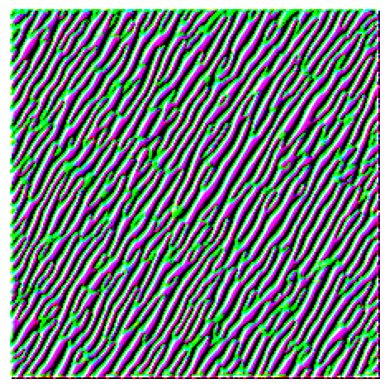

In [20]:
# Visualize a single neurons

target_layer = '3'  # Layer index in VGG16 (e.g., layer 29 = Conv2d-29)
target_neuron = 5  # Neuron index in the layer
iterations = 500
image = visualize_feature(model, target_layer, target_neuron, iterations)
save_and_show_image(image)

Visualized Neurons: [1, 5, 10] in Layer 6 (Conv2d)


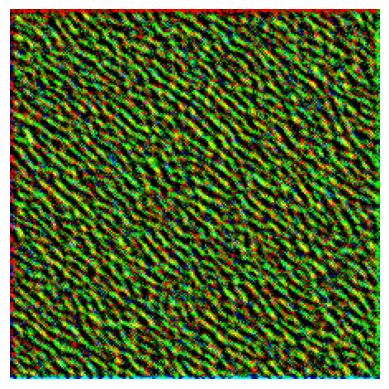

In [27]:
# Visualize a set of neurons

target_layer = '6'
iterations = 500
target_neurons = [1,5,10]
image = visualize_feature(model, target_layer, target_neurons=target_neurons, mode='group')
save_and_show_image(image, filename='feature_visualization_group.png')

Visualized Entire Layer: 16 (MaxPool2d)


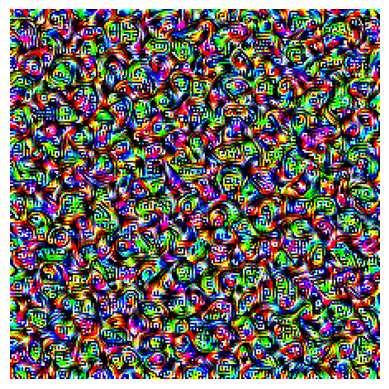

In [ ]:
# Visualize an entire layer

target_layer = '16'
iterations = 100000
image = visualize_feature(model, target_layer, mode='layer')
save_and_show_image(image, filename='feature_visualization_layer.png')